# PMAP_Meds_Appendix: Get patient weight information for our cohort
Created: Jan 25th, 2023

This notebook gets patient weight from out cohort to calculate medication dosage features.

Author: Vina Ro

In [313]:
# Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

file_path = Path('PMAP_Meds.ipynb').resolve()
data_path = file_path.parent.parent.parent.parent.parent.joinpath('Data/jbergma8/IRB_271579_Faraday/IRB-271579-v3-DEID-220607-no-ptsd')

In [339]:
# Import files that document patient weight information
#outpatient = pd.read_csv(data_path / 'outpatient.csv')
#vitals = pd.read_csv(data_path / 'vitals_data.csv', parse_dates=['recorded_time'])
flowsheet = pd.read_csv(data_path / 'flowsheet.csv')
# Import dataframe of our target hospital stays
#CHF_hosp_icu_stays = pd.read_csv('CHF_hosp_icu_stays.csv',parse_dates=['hosp_admsn_time','hosp_disch_time','in_time','out_time'])

d_flo_measures = pd.read_csv(data_path / 'd_flo_measures.csv')

In [340]:
d_flo_measures['disp_name'] = d_flo_measures['disp_name'].str.lower()
d_flo_measures[d_flo_measures['disp_name'].str.contains('weight')]

ValueError: Cannot mask with non-boolean array containing NA / NaN values

In [319]:
flowsheet

,osler_sid,pat_enc_csn_sid,recorded_time,meas_value,meas_comment,meas_id,meas_template_id
0,CEFAE05F-113F-4F73-A31A-0F34EE39B9E2,1.000653e+09,2019-04-19 08:38:00,5.5,NaN,5259,45000
1,8778ACCD-A7CB-4738-B5FB-EBC2E8A3AC7F,1.000328e+09,2017-01-29 17:05:00,Automatic,NaN,301310,16000450600
2,D04D7503-5692-420A-BD3B-4CD1670DA0CD,1.000186e+09,2017-05-14 09:00:00,Yes,NaN,30440100291,30440102200
3,E8F1C9CA-618E-42A3-AFF4-131F13C33D23,1.000547e+09,2021-02-19 07:00:00,137/75,NaN,301260,31010
4,E8F1C9CA-618E-42A3-AFF4-131F13C33D23,1.000547e+09,2021-02-19 04:00:00,Intact,NaN,3040103638,334
...,...,...,...,...,...,...,...
75922995,6C5B28F2-390A-4B9B-812B-921E4E413DFF,1.000401e+09,2021-02-16 11:53:32,0.21,NaN,3042023,304700006
75922996,A1F5E1AF-13E1-47CD-8083-E74DE2AC584F,1.000321e+09,2020-06-18 20:00:00,NPO,NaN,300116,30101
75922997,A1F5E1AF-13E1-47CD-8083-E74DE2AC584F,1.000321e+09,2020-06-19 20:00:00,Sluggish,NaN,301920,30414303
75922998,A1F5E1AF-13E1-47CD-8083-E74DE2AC584F,1.000321e+09,2020-06-22 11:06:00,Seeing;Hearing;Doing,NaN,11130440107353,30440482


In [294]:
# Subset patients in our target cohort that have weight documented specifically used for medication dosing (in kg)
CHF_vitals_dw = vitals[ (vitals.osler_sid.isin(CHF_hosp_icu_stays.osler_sid)) & (vitals.cat == 'dosing-weight')]

merged = pd.merge(left = CHF_hosp_icu_stays[['osler_sid','pat_enc_csn_sid','hosp_admsn_time','hosp_disch_time']],
                  right = CHF_vitals_dw,
                  how = 'left',
                  on = ['osler_sid','pat_enc_csn_sid'])

# Filter out instances where dosing weight documented time is not during hospital stay
merged_filt = merged[merged.recorded_time.between(merged.hosp_admsn_time, merged.hosp_disch_time)]

# gets list of patient IDs who don't have dosing weights documented during the targeted hosp stay, but have dosing weights documented in other hosp stays.
pat_wo_dw_hosp_stay = np.setdiff1d(merged['osler_sid'], merged_filt['osler_sid']) 
print('No. of patients w/o dosing weights documented during hosp stay: ' + str(len(pat_wo_dw_hosp_stay)))

# Group by each hospital stay and get mean of weight
grouped_dw = merged[['osler_sid','pat_enc_csn_sid','num_value']].groupby(['osler_sid','pat_enc_csn_sid'], as_index = False)['num_value'].mean()
grouped_dw.head()

No. of patients w/o dosing weights documented during hosp stay: 1797


,osler_sid,pat_enc_csn_sid,num_value
0,000432FF-214F-460C-9AB9-DB40A7265A82,1000414574,101.790347
1,00081C8C-F7E4-4352-8786-54D8DCDC2AF9,1000468132,58.251605
2,000EE0D9-9115-4281-9F96-D15AC0CBAF4E,1000375948,NaN
3,000F988E-763F-47E7-A92F-980028A69795,1000202595,60.753996
4,000FC796-7639-402E-BA61-CEC8AD52C5E2,1000010641,72.063987


In [296]:
grouped_dw

,osler_sid,pat_enc_csn_sid,num_value
0,000432FF-214F-460C-9AB9-DB40A7265A82,1000414574,101.790347
1,00081C8C-F7E4-4352-8786-54D8DCDC2AF9,1000468132,58.251605
2,000EE0D9-9115-4281-9F96-D15AC0CBAF4E,1000375948,NaN
3,000F988E-763F-47E7-A92F-980028A69795,1000202595,60.753996
4,000FC796-7639-402E-BA61-CEC8AD52C5E2,1000010641,72.063987
...,...,...,...
4483,FFD7AAF8-E048-43CF-BA9C-7E41BB86AA1E,1000447878,110.998460
4484,FFE0640C-3AFF-485F-8DA8-EFB313567864,1000360263,90.880585
4485,FFE68A1A-2EB6-4687-87E4-9D2495B14134,1000328439,NaN
4486,FFEDBC8A-4706-41DA-8C1B-F7F03715ABBB,1000367783,99.788632


In [295]:
grpd_wo_dw_hosp_stay = CHF_vitals_dw[CHF_vitals_dw.osler_sid.isin(pat_wo_dw_hosp_stay)].groupby(['osler_sid'], as_index = False)['num_value'].mean()
print(grpd_wo_dw_hosp_stay

,osler_sid,num_value
0,000EE0D9-9115-4281-9F96-D15AC0CBAF4E,80.283090
1,003DED1B-9FA1-411F-85C8-B11EBC72909E,69.920885
2,0044072C-6E12-4EFC-8C56-3C13047C1B21,122.558719
3,006DDC4F-FCE6-40A0-92DF-C54DD054B466,76.086853
4,00C4A461-735C-487C-8648-53B247DE9791,50.044420
...,...,...
868,FDE5F350-043A-4026-82D4-7660DFCB9EF2,43.972265
869,FE67D07C-23D6-438E-B563-AA3082C050F9,78.219447
870,FF58277A-4F0C-462C-81BB-6EEB25A1545B,86.656908
871,FF9F439B-AD23-4C5D-A06C-88051512DF00,84.474981


In [297]:
grpd_wo_dw_hosp_stay.osler_sid.nunique()

873

,osler_sid,pat_enc_csn_sid,num_value_x,num_value_y
0,000432FF-214F-460C-9AB9-DB40A7265A82,1000414574,101.790347,NaN
1,00081C8C-F7E4-4352-8786-54D8DCDC2AF9,1000468132,58.251605,NaN
2,000EE0D9-9115-4281-9F96-D15AC0CBAF4E,1000375948,NaN,80.283090
3,000F988E-763F-47E7-A92F-980028A69795,1000202595,60.753996,NaN
4,000FC796-7639-402E-BA61-CEC8AD52C5E2,1000010641,72.063987,NaN
...,...,...,...,...
4483,FFD7AAF8-E048-43CF-BA9C-7E41BB86AA1E,1000447878,110.998460,NaN
4484,FFE0640C-3AFF-485F-8DA8-EFB313567864,1000360263,90.880585,NaN
4485,FFE68A1A-2EB6-4687-87E4-9D2495B14134,1000328439,NaN,89.879799
4486,FFEDBC8A-4706-41DA-8C1B-F7F03715ABBB,1000367783,99.788632,NaN


1120


209

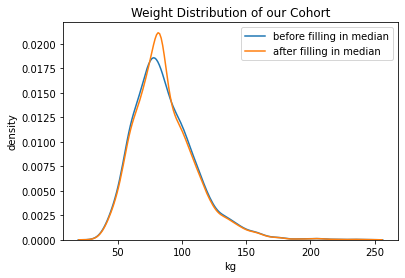

In [305]:
merged = pd.merge(left = grouped_dw, right = grpd_wo_dw_hosp_stay, how = 'left', on = 'osler_sid')
display(merged)
pat_wo_wt = merged[(merged.num_value_x.isnull()) & (merged.num_value_y.isnull())]['osler_sid']
print(len(pat_wo_wt))
temp = outpatient[outpatient.osler_sid.isin(pat_wo_wt)][['osler_sid','weight']]
pat_wo_wt = temp.groupby('osler_sid', as_index = False)['weight'].mean()
pat_wo_wt['weight'] = pat_wo_wt['weight'] * 0.0283495 # convert oz to kg

merged['num_value_x'] = merged.num_value_x.fillna(merged.pop('num_value_y'))


weights = pd.merge(left = merged, right = pat_wo_wt, how = 'left', on = 'osler_sid')
weights['num_value_x'] = weights['num_value_x'].fillna(weights.pop('weight'))
weights = weights.rename({'num_value_x':'weight'}, axis = 1)
display(len(weights[weights.weight.isnull()]))
#plt.hist(weights['weight'], bins = 30)
sns.kdeplot(data = weights, x="weight", label = 'before filling in median')

plt.title('Weight Distribution of our Cohort')
plt.xlabel('kg')
plt.ylabel('density')

weights['weight'] = weights['weight'].fillna(weights['weight'].median())

sns.kdeplot(data = weights, x="weight", label = 'after filling in median')
plt.legend()
plt.show()
weights.to_csv('weights.csv', index = False)

In [300]:
pat_wo_wt

,osler_sid,weight
0,003DE79D-3145-4604-811E-CEADAE65F2D4,71.429400
1,00601B94-0F8B-44B3-BB01-C8FE638E9510,NaN
2,0091D788-797D-4FC7-A3E1-0E83A0B1E0E3,NaN
3,00CB4C63-E9ED-454B-8CA6-511F05750036,80.397283
4,00D14078-4BA2-4C6C-B374-0D12EDBECF91,NaN
...,...,...
1074,FEC822FE-A56F-475C-B6CB-DEA44611A6AD,78.007744
1075,FECCB41D-CE40-4F79-9B75-FB63676AB13C,93.167797
1076,FF3F93E0-3363-4F99-972E-70C7918F51E3,71.622177
1077,FF8175B2-FED6-4CEF-9A8F-E9C28F4549A3,71.880666


In [301]:
merged

,osler_sid,pat_enc_csn_sid,num_value_x
0,000432FF-214F-460C-9AB9-DB40A7265A82,1000414574,101.790347
1,00081C8C-F7E4-4352-8786-54D8DCDC2AF9,1000468132,58.251605
2,000EE0D9-9115-4281-9F96-D15AC0CBAF4E,1000375948,80.283090
3,000F988E-763F-47E7-A92F-980028A69795,1000202595,60.753996
4,000FC796-7639-402E-BA61-CEC8AD52C5E2,1000010641,72.063987
...,...,...,...
4483,FFD7AAF8-E048-43CF-BA9C-7E41BB86AA1E,1000447878,110.998460
4484,FFE0640C-3AFF-485F-8DA8-EFB313567864,1000360263,90.880585
4485,FFE68A1A-2EB6-4687-87E4-9D2495B14134,1000328439,89.879799
4486,FFEDBC8A-4706-41DA-8C1B-F7F03715ABBB,1000367783,99.788632
